# Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd



repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import astartes as at
from astartes import train_test_split, train_val_test_split

from alinemol.utils import eval_roc_auc, eval_pr_auc, eval_acc, rescale, compute_linear_fit
from alinemol.utils import plot_ID_OOD, plot_ID_OOD_sns #visualize_chemspace
from alinemol.utils import split_molecules_train_test, split_molecules_train_val_test

#from alinemol.splitters import ScaffoldSplit, RandomSplit, SphereExclusionSplit, KMeansSplit, DBScanSplit, OptiSimSplit

light_color = plt.get_cmap("plasma").colors[170]
#dark_color = plt.get_cmap("plasma").colors[5]
dark_color = "black"


#matplotlib.use("pgf")

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 20,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

In [11]:
import umap
import datamol as dm
def visualize_chemspace(data: pd.DataFrame, split_names, mol_col: str = "smiles", size_col=None, size=10):
    """
    Visualize chemical space using UMAP

    Args:
        data (pd.DataFrame): pd.DataFrame with columns "smiles", "label", "split"
        split_names (list): list of split names
        mol_col (str): name of column containing SMILES
        size_col: name of column containing size information
    
    Returns:
        None
    """
    figs = plt.figure(num=3)
    features = [dm.to_fp(mol) for mol in data[mol_col]]
    embedding = umap.UMAP().fit_transform(features)
    data["UMAP_0"], data["UMAP_1"] = embedding[:, 0], embedding[:, 1]
    for split_name in split_names:
        plt.figure(figsize=(12, 8))
        fig = sns.scatterplot(data=data, x="UMAP_0", y="UMAP_1", s=size, style=size_col, hue=split_name, alpha=0.7)
        fig.set_title(f"UMAP Embedding of compounds for {split_name} split")
    return figs

# Visualize the splits in 2D

In [12]:
dataset_categoty = "TDC"
dataset_name = "CYP2C19"
split_type = "optisim"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type)

train_path = os.path.join(SPLIT_PATH, "train.csv")
external_test_path = os.path.join(SPLIT_PATH, "external_test.csv")

train_df = pd.read_csv(train_path)
external_test_df = pd.read_csv(external_test_path)

In [13]:
train_test_list = ["train"]*len(train_df) + ["external_test"]*len(external_test_df)
split_df = pd.concat([train_df, external_test_df])
split_df[split_type] = train_test_list

In [14]:
split_df[split_type].value_counts()

optisim
train            11458
external_test     1207
Name: count, dtype: int64

In [15]:
split_df

,smiles,label,optisim
0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0,train
1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,train
2,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1,train
3,Br.N=c1n(CCN2CCOCC2)c2ccccc2n1CC(=O)c1ccc(Cl)c...,1,train
4,CCc1cc2c(=O)[nH]cnc2s1,0,train
...,...,...,...
1202,Cn1c(=O)n2n(c1=O)[C@H]1[C@H](O)[C@H]3O[C@@H]3/...,0,external_test
1203,O=C1C2=CC[C@@H]3C(=O)N(c4ccc(F)cc4F)C(=O)[C@H]...,0,external_test
1204,CCN1C(=O)[C@@H]2CC=C3C(=O)[C@H]4O[C@H]4[C@@H](...,0,external_test
1205,Cn1c(=O)n2n(c1=O)[C@@H]1[C@H](CC2)C(=O)[C@@H]2...,0,external_test


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

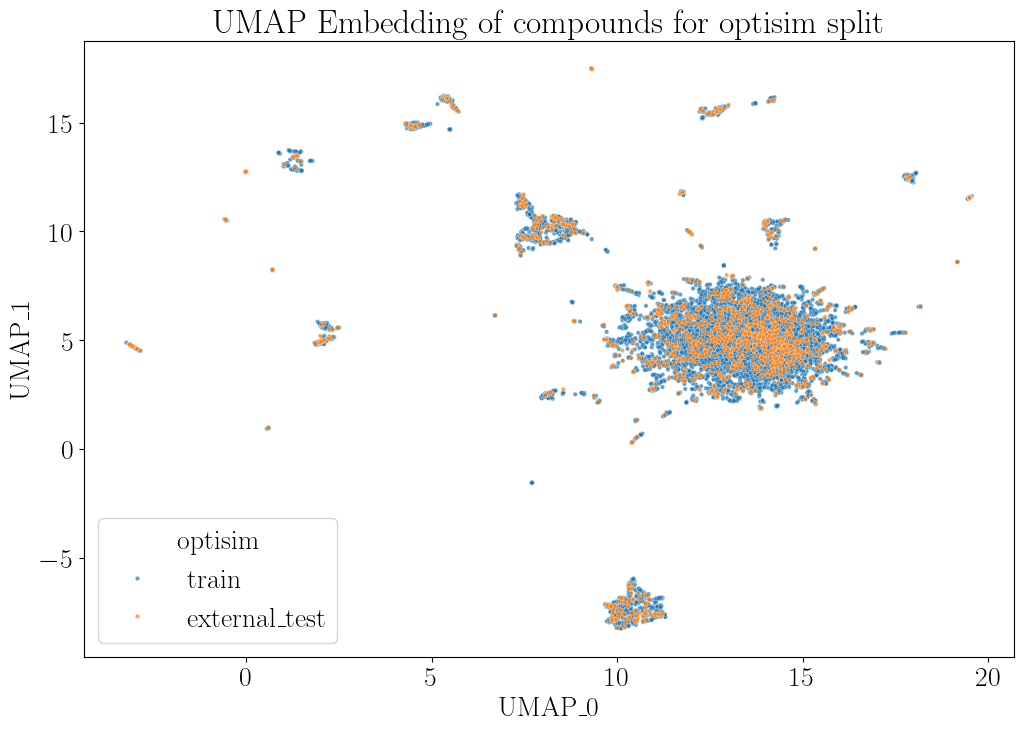

In [16]:
visualize_chemspace(split_df, split_names=[split_type], size=10)

In [17]:
import datamol as dm
import splito

In [18]:
DF_PATH = os.path.join(DATASET_PATH, "TDC", "CYP2C19", "CYP2C19_simplified.csv")
data = pd.read_csv(DF_PATH)
data.shape

(12665, 2)

In [19]:
# Define scaffold split
splitter = splito.ScaffoldSplit(smiles=data.smiles.tolist(), n_jobs=-1, test_size=0.1, random_state=111)

In [20]:
train_idx, test_idx = next(splitter.split(X=data["smiles"].values))
assert train_idx.shape[0] > test_idx.shape[0]

In [21]:
data.loc[train_idx, "ScaffoldSplit"] = "train"
data.loc[test_idx, "ScaffoldSplit"] = "test"
data["scaffold"] = splitter.scaffolds

In [22]:
data["ScaffoldSplit"].value_counts()

ScaffoldSplit
train    11414
test      1251
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

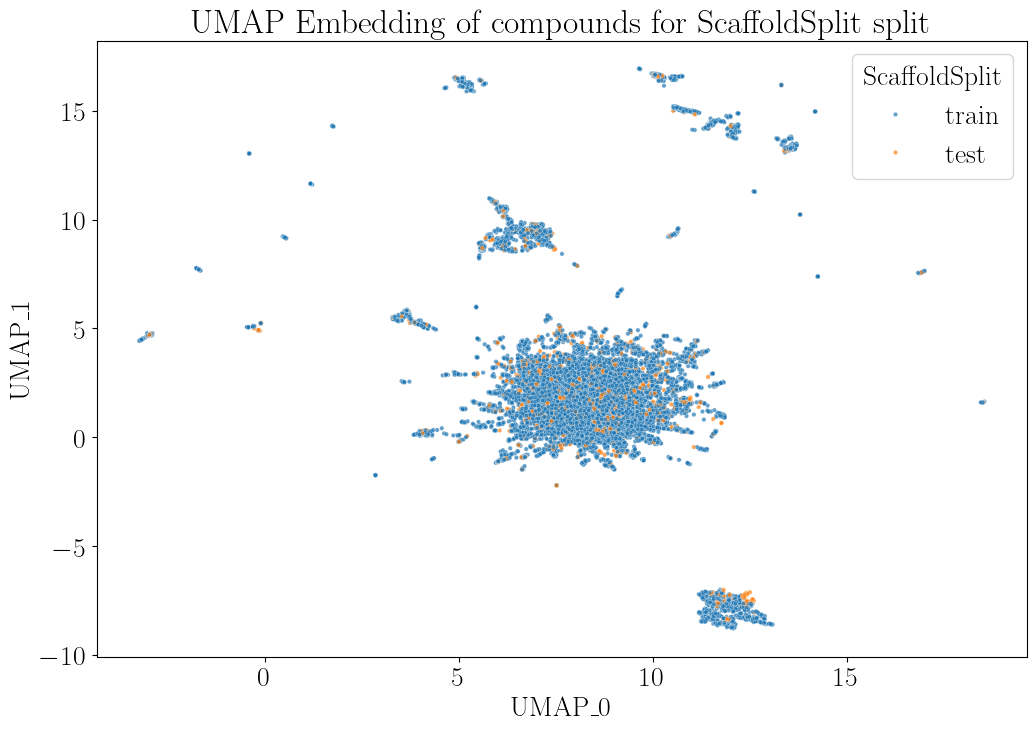

In [24]:
visualize_chemspace(data, split_names=["ScaffoldSplit"], size=10)

In [25]:
data

,smiles,label,ScaffoldSplit,scaffold,UMAP_0,UMAP_1
0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0,train,c1ccc(N2CCNCC2)cc1,9.557853,3.139632
1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,train,O=c1oc2ccc(NS(=O)(=O)c3cccs3)cc2s1,7.717187,1.656112
2,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1,train,c1ccc(-c2n[nH]c(-c3ccccc3)n2)cc1,9.522059,0.786873
3,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1,train,c1ccc(C(c2nnn[nH]2)N2CCN(Cc3ccncc3)CC2)cc1,9.813725,0.699903
4,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1,train,O=C(Cn1nnc(-c2ccncc2)n1)NCc1ccccc1,8.179121,3.715858
...,...,...,...,...,...,...
12660,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,0,train,O=C1NC(=O)[C@@H]2CC[C@@H]3C(=O)C=CC[C@H]3[C@H]12,5.097229,16.109467
12661,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,0,train,O=C1[C@H]2[C@H](CC=C3[C@H]2C[C@H]2O[C@@H]2C32O...,6.363259,3.586334
12662,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,1,test,O=C1NC(=O)[C@H]2CC=C3[C@@H](C[C@H]4O[C@@H]4C34...,6.338778,3.489323
12663,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,0,train,O=C1CCC[C@H]2[C@@H]3C(=O)N(Cc4ccccc4)C(=O)[C@@...,5.342569,16.228552


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

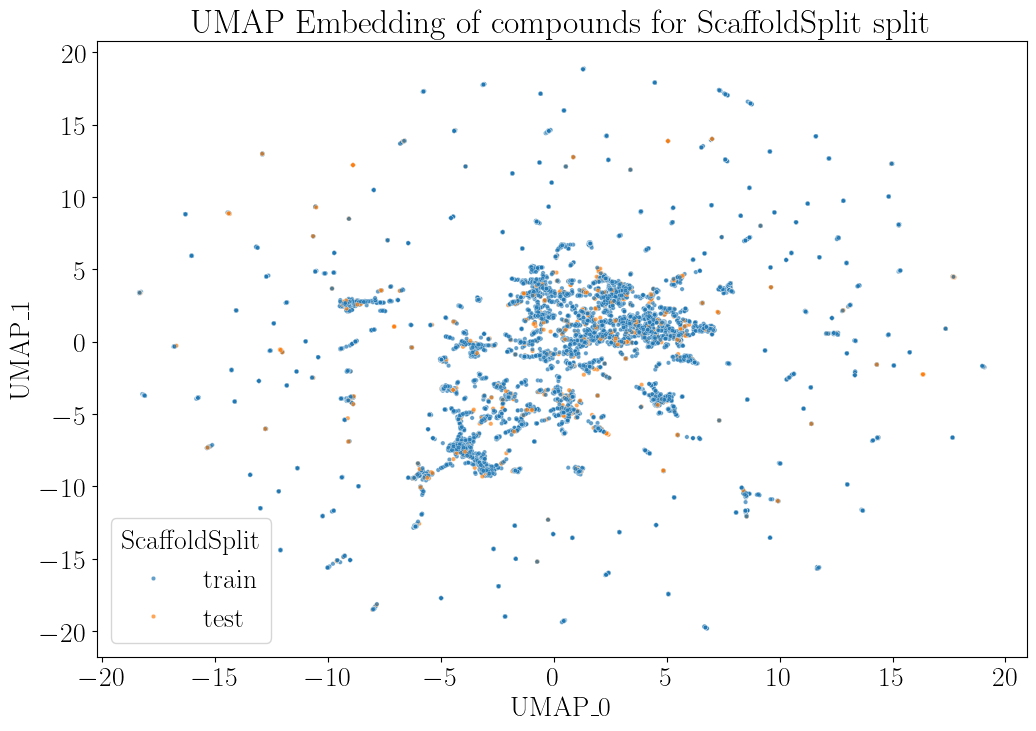

In [26]:
visualize_chemspace(data, split_names=["ScaffoldSplit"], mol_col="scaffold")

In [ ]:
# Define PerimeterSplit
splitter = splito.PerimeterSplit(n_jobs=-1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=data["smiles"].values))

assert train_idx.shape[0] > test_idx.shape[0]

data.loc[train_idx, splito.PerimeterSplit.__name__] = "train"
data.loc[test_idx, splito.PerimeterSplit.__name__] = "test"

In [ ]:
# Define PerimeterSplit
splitter = splito.MaxDissimilaritySplit(n_jobs=-1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=data.smiles.values))
assert train_idx.shape[0] > test_idx.shape[0]

data.loc[train_idx, "MaxDissimilaritySplit"] = "train"
data.loc[test_idx, "MaxDissimilaritySplit"] = "test"

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

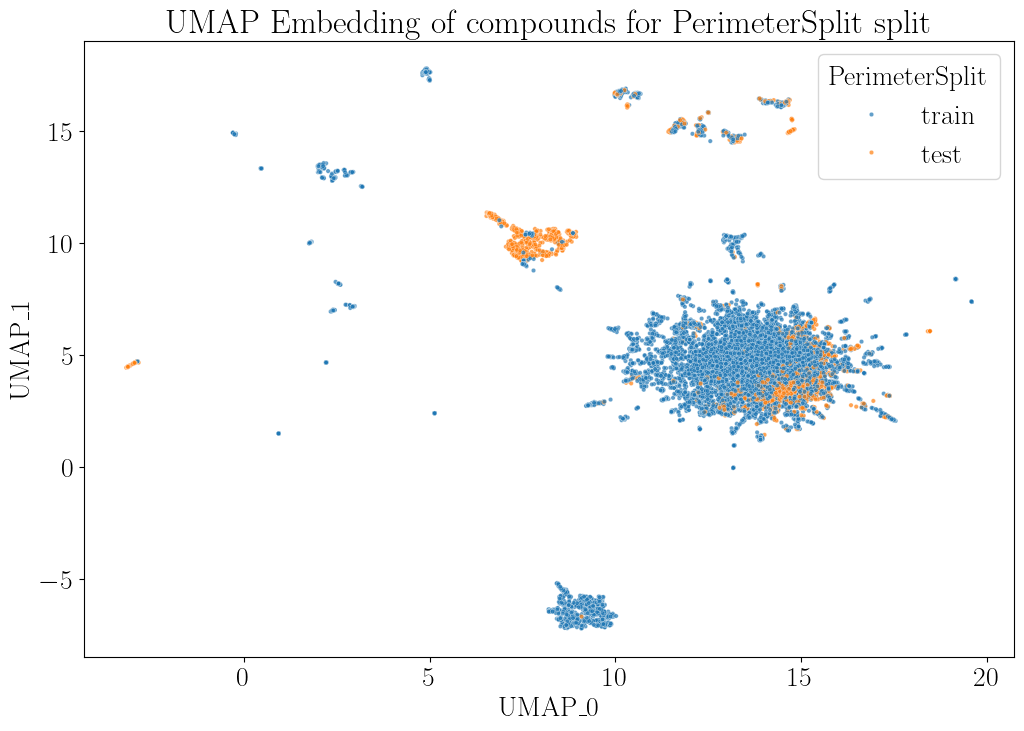

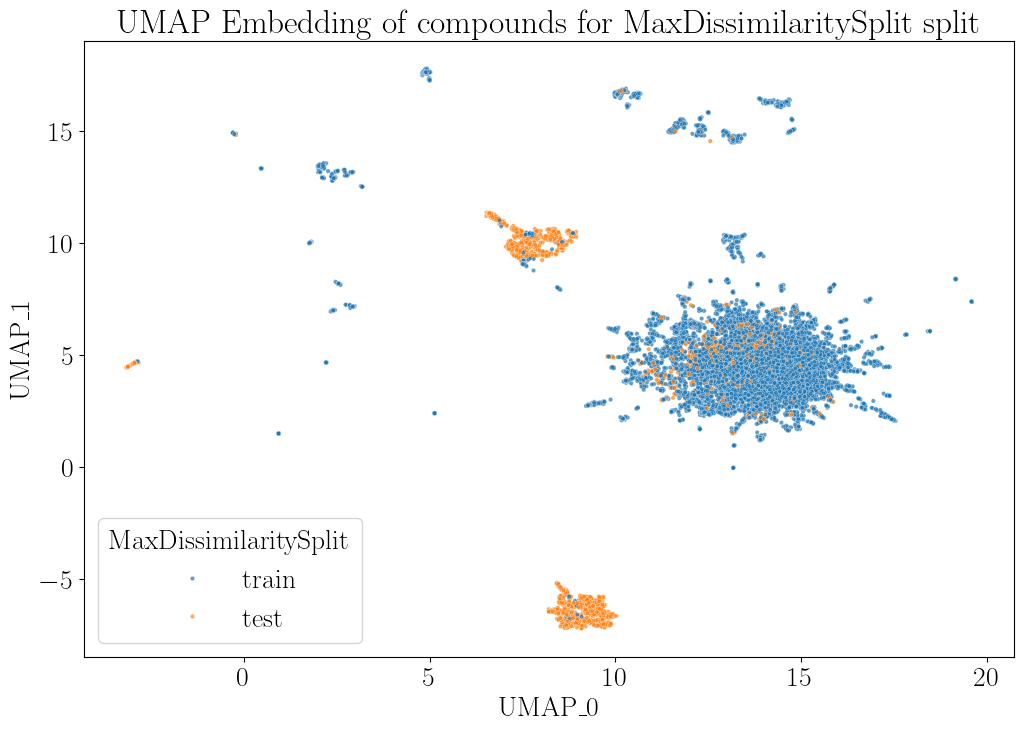

In [29]:
visualize_chemspace(data, split_names=["PerimeterSplit", "MaxDissimilaritySplit"])

##